# League of Legends Analysis Portfolio\nAnalysis of High Diamond Ranked Matches within the first 10 minutes.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_absolute_error, r2_score, silhouette_score
from matplotlib.backends.backend_pdf import PdfPages

# Set plot style
sns.set(style="whitegrid")
%matplotlib inline


In [2]:
class ReportGenerator:
    def __init__(self, filename="LoL_Analysis_Report.pdf"):
        self.filename = filename
        self.pdf = PdfPages(self.filename)
        print(f"Initialized Report Generator: {self.filename}")

    def add_plot(self, fig=None, title=None):
        if fig is None:
            fig = plt.gcf()
        if title:
            fig.suptitle(title, fontsize=14, fontweight='bold')
        self.pdf.savefig(fig, bbox_inches='tight')
        print(f"Saved plot to report: {title if title else 'Untitled'}")

    def add_text_page(self, title, text_content):
        fig = plt.figure(figsize=(11, 8.5))
        plt.axis('off')
        plt.text(0.5, 0.9, title, ha='center', va='top', fontsize=20, fontweight='bold')
        plt.text(0.1, 0.8, text_content, ha='left', va='top', fontsize=12, wrap=True)
        self.pdf.savefig(fig)
        plt.close(fig)
        print(f"Saved text page to report: {title}")

    def save_report(self):
        self.pdf.close()
        print(f"Report successfully saved to {self.filename}")


In [3]:
class LoLDataHandler:
    def __init__(self, filepath, report_gen=None):
        self.filepath = filepath
        self.df_raw = None
        self.cleanup_df = None
        self.report_gen = report_gen

    def load_data(self):
        print(f"Loading data from {self.filepath}...")
        self.df_raw = pd.read_csv(self.filepath)
        return self.df_raw

    def display_df_summary(self):
        df = self.df_raw
        print("Dataset Shape:", df.shape)
        print("\nDataset Info:")
        print(df.info())
        print("\nDescriptive Statistics:")
        print(df.describe())
        print("\nFirst 5 Rows:")
        print(df.head())

    def generate_cleanup_summary(self):
        df = self.df_raw
        missing_val = df.isnull().sum()
        zero_val = (df == 0).sum()
        self.cleanup_df = pd.DataFrame({
            'Missing Values': missing_val,
            'Missing %': (missing_val / len(df)) * 100,
            'Zero Values': zero_val,
            'Zero %': (zero_val / len(df)) * 100
        })

    def check_constant_columns(self):
        constant_cols = [col for col in self.df_raw.columns if self.df_raw[col].nunique() == 1]
        print(f"\nConstant Columns (Invariant): {len(constant_cols)}")

    def check_missing_values(self):
        missing_count = self.df_raw.isnull().sum().sum()
        print(f"\nTotal Missing Values in Dataset: {missing_count}")

    def visualize_cleanup(self, threshold=50):
        if self.cleanup_df is None:
            self.generate_cleanup_summary()
        zero_cols = self.cleanup_df[self.cleanup_df['Zero %'] > threshold]
        print(f"\n== Columns with more than {threshold}% zeros ==")
        
        fig = plt.figure(figsize=(12, 6))
        self.cleanup_df[['Zero %', 'Missing %']].plot(kind='bar', figsize=(12, 6), ax=plt.gca())
        plt.title("Percentage of Zeros and Missing Values per Column")
        plt.ylabel("Percentage (%)")
        plt.xlabel("Columns")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        if self.report_gen: self.report_gen.add_plot(fig, "Data Quality Check")

    def visualize_data_exploration(self):
        df = self.df_raw
        print("\n== Generating Data Exploration Visualisations ==")
        
        # 1. Class Balance
        fig1 = plt.figure(figsize=(8,6))
        sns.countplot(x='blueWins', data=df)
        plt.title("Class Distribution of Match Outcomes")
        plt.show()
        if self.report_gen: self.report_gen.add_plot(fig1, "Class Balance")
        
        # 2. Correlation
        fig2 = plt.figure(figsize=(14, 10))
        sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
        plt.title("Correlation Matrix")
        plt.show()
        if self.report_gen: self.report_gen.add_plot(fig2, "Correlation Matrix")

        # 3. Histograms
        fig3 = plt.figure(figsize=(10, 8))
        numeric_features = ['blueTotalGold', 'redTotalGold', 'blueKills', 'redKills']
        df[numeric_features].hist(bins=20, figsize=(10, 8))
        plt.suptitle("Distribution of Core Gameplay Metrics", y=1.02)
        plt.show()
        if self.report_gen: self.report_gen.add_plot(plt.gcf(), "Metric Distributions")

    def run_full_analysis(self, zero_threshold=50):
        print("=" * 80)
        print("LOLRanked DATA ANALYSIS PIPELINE")
        print("=" * 80)
        self.display_df_summary()
        self.generate_cleanup_summary()
        self.check_constant_columns()
        self.check_missing_values()
        self.visualize_cleanup(threshold=zero_threshold)
        self.visualize_data_exploration()
        print("\n" + "=" * 80)
        print("ANALYSIS COMPLETE")
        print("=" * 80)


In [4]:
class LoLDataCleaner:
    def __init__(self, df_raw):
        self.df_raw = df_raw
        self.df_cleaned = df_raw.copy()
        self.all_dropped = []

    def remove_leaking_features(self):
        cols_before = set(self.df_cleaned.columns)
        leaking_cols = [
            'blueGoldDiff', 'redGoldDiff', 'blueExperienceDiff', 'redExperienceDiff',
            'blueTotalGold', 'redTotalGold', 'blueTotalExperience', 'redTotalExperience',
            'blueGoldPerMin', 'blueCSPerMin', 'redGoldPerMin', 'redCSPerMin', 'redFirstBlood', 'gameId'
        ]
        cols_to_drop = [col for col in leaking_cols if col in self.df_cleaned.columns]
        self.df_cleaned = self.df_cleaned.drop(columns=cols_to_drop)
        dropped = list(cols_before - set(self.df_cleaned.columns))
        self.all_dropped.extend(dropped)
        print(f"\n[1] LEAKAGE REMOVAL: Dropped {len(dropped)} columns.")
        return self.df_cleaned

    def apply_standardized_ratios(self):
        cols_before = set(self.df_cleaned.columns)
        pairs = [
            ('blueKills', 'redKills', 'killsRatio'),
            ('blueAssists', 'redAssists', 'assistsRatio'),
            ('blueTotalMinionsKilled', 'redTotalMinionsKilled', 'minionsRatio'),
            ('blueTotalJungleMinionsKilled', 'redTotalJungleMinionsKilled', 'jungleRatio')
        ]
        new_features = []
        for blue_col, red_col, new_name in pairs:
            if blue_col in self.df_cleaned.columns and red_col in self.df_cleaned.columns:
                self.df_cleaned[new_name] = (self.df_cleaned[blue_col] - self.df_cleaned[red_col]) / \
                                            (self.df_cleaned[blue_col] + self.df_cleaned[red_col] + 1e-9)
                self.df_cleaned = self.df_cleaned.drop(columns=[blue_col, red_col])
                new_features.append(new_name)
        dropped = list(cols_before - set(self.df_cleaned.columns))
        self.all_dropped.extend(dropped)
        print(f"\n[2] RATIO TRANSFORMATION: Dropped {len(dropped)} raw component columns.")
        print(f"    -> Created: {new_features}")
        return self.df_cleaned

    def run_full_cleanup(self):
        print(f"STARTING CLEANUP: {len(self.df_raw.columns)} initial columns.")
        self.remove_leaking_features()
        self.apply_standardized_ratios()
        print(f"\nCLEANUP COMPLETE: {len(self.df_cleaned.columns)} columns remaining.")
        print("-" * 30)
        return self.df_cleaned


In [5]:
class DimensionalityReducer:
    def __init__(self, df, feature_columns, report_gen=None):
        self.df = df
        self.feature_columns = feature_columns
        self.X_scaled = None
        self.X_umap = None
        self.X_tsne = None
        self.report_gen = report_gen

    def prepare_data(self):
        X_cluster = self.df[self.feature_columns]
        scaler = StandardScaler()
        self.X_scaled = scaler.fit_transform(X_cluster)
        return self.X_scaled

    def run_reductions(self):
        # 1. t-SNE (Matches User Params)
        print("Running t-SNE...")
        tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random', random_state=42)
        self.X_tsne = tsne.fit_transform(self.X_scaled)

        # 2. UMAP (Matches User Params)
        print("Running UMAP...")
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
        self.X_umap = reducer.fit_transform(self.X_scaled)
        
        return self.X_tsne, self.X_umap

    def analyze_component_correlations(self):
        # Creates the 'Shap-style' bar plots from the user snippet
        df_umap = pd.DataFrame(self.X_umap, columns=['UMAP1', 'UMAP2'])
        df_scaled = pd.DataFrame(self.X_scaled, columns=self.feature_columns)
        
        loadings_umap = pd.DataFrame({
            'UMAP1': df_scaled.corrwith(df_umap['UMAP1']),
            'UMAP2': df_scaled.corrwith(df_umap['UMAP2'])
        })
        
        self.shap_style_bar_plot(loadings_umap, title='UMAP Feature Correlations')

    def shap_style_bar_plot(self, loadings, title=''):
        for col in loadings.columns:
            fig = plt.figure(figsize=(8, len(loadings) * 0.35 + 2))
            features = loadings.index
            values = loadings[col].values
            colors = ['blue' if v > 0 else 'red' for v in values]
            y_pos = np.arange(len(features))
            plt.barh(y_pos, values, color=colors, alpha=0.7, edgecolor='k')
            plt.yticks(y_pos, features)
            plt.axvline(0, color='grey', linestyle='--')
            plt.xlabel(f'Correlation with {col}')
            plt.title(f'{title} - {col}')
            plt.grid(axis='x', linestyle='--', alpha=0.4)
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            if self.report_gen: self.report_gen.add_plot(fig, f"Correlations {col}")

    def plot_reductions(self):
        df_vis = pd.DataFrame({
            'TSNE1': self.X_tsne[:, 0], 'TSNE2': self.X_tsne[:, 1],
            'UMAP1': self.X_umap[:, 0], 'UMAP2': self.X_umap[:, 1]
        })
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        axes[0].scatter(df_vis['TSNE1'], df_vis['TSNE2'], s=10, alpha=0.7, c='royalblue')
        axes[0].set_title("t-SNE Visualization")
        axes[0].set_xlabel("TSNE1: Objective Dominance & Team Performance")
        axes[0].set_ylabel("TSNE2: Dragon Priority vs. Herald/Kill Trade")

        axes[1].scatter(df_vis['UMAP1'], df_vis['UMAP2'], s=10, alpha=0.7, c='seagreen')
        axes[1].set_title("UMAP Visualization")
        axes[1].set_xlabel("UMAP1: Objective Dominance & Team Performance")
        axes[1].set_ylabel("UMAP2: Dragon Priority vs. Herald/Kill Trade")
        
        plt.tight_layout()
        plt.show()
        if self.report_gen: self.report_gen.add_plot(fig, "t-SNE vs UMAP")


In [6]:
class ClusterAnalyzer:
    def __init__(self, X_scaled, random_state=42, report_gen=None):
        self.X_scaled = X_scaled
        self.random_state = random_state
        self.report_gen = report_gen

    def find_optimal_k(self, k_range=range(1, 11)):
        inertia = []
        silhouette_scores = []
        print("Calculating Inertia and Silhouette Scores...")
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
            kmeans.fit(self.X_scaled)
            inertia.append(kmeans.inertia_)
            if k > 1:
                silhouette_scores.append(silhouette_score(self.X_scaled, kmeans.labels_))
            else:
                silhouette_scores.append(None)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        axes[0].plot(k_range, inertia, marker='o', linestyle='--', color='b')
        axes[0].set_title('Elbow Method')
        axes[0].set_xlabel('Number of Clusters (k)')
        axes[0].set_ylabel('Inertia (Sum of Squared Distances)')
        
        axes[1].plot(list(k_range)[1:], silhouette_scores[1:], marker='o', linestyle='--', color='g')
        axes[1].set_title('Silhouette Method')
        axes[1].set_xlabel('Number of Clusters (k)')
        axes[1].set_ylabel('Silhouette Score')
        
        plt.tight_layout()
        plt.show()
        if self.report_gen: self.report_gen.add_plot(fig, "Clustering Optimization")

    def cluster_on_umap_and_visualize(self, X_umap, n_clusters=5):
        # User Code Logic: Fit clusters to the UMAP coordinates
        kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_state, n_init=10)
        clusters = kmeans.fit_predict(X_umap)

        df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
        df_umap['Cluster'] = clusters

        fig = plt.figure(figsize=(12, 8))
        sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', data=df_umap, palette='viridis', alpha=0.8, s=15)
        plt.title('Refined Game Archetypes: Clustering on UMAP Output')
        plt.xlabel('UMAP1 (Snowballing: Heralds, XP, Gold)')
        plt.ylabel('UMAP2 (Dragon Control vs. Feeding)')
        plt.legend(title='Cluster ID', loc='best')
        plt.show()
        if self.report_gen: self.report_gen.add_plot(fig, "UMAP Clusters")
        return clusters

    def analyze_win_rates(self, df_full, cluster_feature_columns, n_clusters=5):
        # User Code Logic: Cluster on SPECIFIC feature columns (Raw Data)
        # Note: The snippet re-defines 'feature_columns_cluster' right before this step.
        # We will pass that specific list in.
        
        # Ensure blueWins is present
        if 'blueWins' not in df_full.columns:
            raise ValueError("The column 'blueWins' is missing.")

        X_clustering = df_full[cluster_feature_columns]
        kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_state, n_init=10)
        
        df_in = df_full.copy()
        df_in['Cluster'] = kmeans.fit_predict(X_clustering)

        # Calculate Mean Win Rate & Stats
        interpretation_cols = ['blueWins', 'blueEliteMonsters', 'blueDeaths', 'killsRatio']
        cluster_win_analysis = df_in.groupby('Cluster')[interpretation_cols].mean()
        cluster_win_analysis['Game_Count'] = df_in['Cluster'].value_counts()
        cluster_win_analysis = cluster_win_analysis.sort_values('blueWins', ascending=False)
        
        print("\n--- CLUSTER WIN RATE INTERPRETATION ---")
        print(cluster_win_analysis.round(3))
        
        # Plot
        umap_colors = {0: "#440154", 1: "#3b528b", 2: "#21918c", 3: "#5ec962", 4: "#fde725"}
        plot_order = cluster_win_analysis.index
        palette_ordered = [umap_colors.get(i, "#000000") for i in plot_order]
        
        fig = plt.figure(figsize=(10, 6))
        sns.barplot(x=cluster_win_analysis.index, y=cluster_win_analysis['blueWins'], palette=palette_ordered, order=plot_order, edgecolor="black")
        plt.axhline(0.5, color='red', linestyle='--', alpha=0.7, label='50% Win Rate')
        plt.title("Win Rate by Cluster (Colors Matched to UMAP Archetypes)")
        plt.ylabel("Win Rate (0.0 - 1.0)")
        plt.xlabel("Cluster ID")
        plt.ylim(0, 0.8)
        plt.legend()
        plt.show()
        if self.report_gen: self.report_gen.add_plot(fig, "Win Rate by Cluster")
        
        return cluster_win_analysis, df_in['Cluster'] # Return clusters for stats mapping if needed


In [7]:
class ModelTrainer:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = self._get_classifiers()

    def _get_classifiers(self):
        return {
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=self.random_state),
            "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=self.random_state),
            "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, random_state=self.random_state)),
            "Naïve Bayes": GaussianNB(),
            "SVM (RBF)": make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, probability=True, random_state=self.random_state))
        }

    def evaluate_model(self, model_name, clf, X_train, X_test, y_train, y_test, dataset_type):
        print(f"Testing {model_name} on {dataset_type} Data...")
        start_train = time.time()
        clf.fit(X_train, y_train)
        end_train = time.time()
        start_infer = time.time()
        predictions = clf.predict(X_test)
        end_infer = time.time()
        
        return {
            'Model': model_name,
            'Dataset': dataset_type,
            'Accuracy': accuracy_score(y_test, predictions),
            'F1 Score': f1_score(y_test, predictions),
            'Precision': precision_score(y_test, predictions),
            'Recall': recall_score(y_test, predictions),
            'Train Time (sec)': end_train - start_train,
            'Inference Time (sec)': end_infer - start_infer
        }

class ExperimentRunner:
    def __init__(self, trainer, report_gen=None):
        self.trainer = trainer
        self.report_gen = report_gen

    def run_classifier_comparison(self, datasets):
        results_list = []
        y_train = datasets['y_train']
        y_test = datasets['y_test']

        for name, model in self.trainer.models.items():
            for dtype in ['Raw', 'Clusters', 'Combined']:
                results_list.append(self.trainer.evaluate_model(name, model, datasets[dtype]['X_train'], datasets[dtype]['X_test'], y_train, y_test, dtype))
        return pd.DataFrame(results_list)

    def visualize_results(self, results_df, optimal_k):
        # Quality Plot
        plot_df = results_df.melt(id_vars=['Model', 'Dataset'], value_vars=['Accuracy', 'F1 Score'], var_name='Metric', value_name='Score')
        g = sns.catplot(data=plot_df, kind="bar", x="Metric", y="Score", hue="Model", col="Dataset", height=5, aspect=1.0, palette="viridis")
        g.fig.suptitle(f'Algorithm Quality (k={optimal_k})', y=1.05)
        plt.show()
        if self.report_gen: self.report_gen.add_plot(g.fig, "Algorithm Quality Comparison")

        # Efficiency Plot
        time_df = results_df.melt(id_vars=['Model', 'Dataset'], value_vars=['Train Time (sec)'], var_name='Task', value_name='Time (Seconds)')
        fig = plt.figure(figsize=(12, 6))
        sns.barplot(x='Model', y='Time (Seconds)', hue='Dataset', data=time_df, palette='magma')
        plt.yscale('log')
        plt.title('Training Efficiency')
        plt.show()
        if self.report_gen: self.report_gen.add_plot(fig, "Training Efficiency")

    def run_regression_analysis(self, df_classification, gb_model, X_combined, df_raw_blueGoldDiff):
        experiments = [
            {"title": "With WinProb", "use_win_prob": True, "color": "red"},
            {"title": "Without WinProb", "use_win_prob": False, "color": "green"}
        ]
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        for ax, exp in zip(axes, experiments):
            df_reg = df_classification.copy()
            if 'WinProbability' in df_reg.columns: df_reg.drop(columns=['WinProbability'], inplace=True)
            if exp["use_win_prob"]: df_reg['WinProbability'] = gb_model.predict_proba(X_combined)[:, 1]
            if 'blueGoldDiff' not in df_reg.columns: df_reg['blueGoldDiff'] = df_raw_blueGoldDiff

            y_reg = df_reg['blueGoldDiff']
            X_reg = df_reg.drop(columns=['blueWins', 'blueGoldDiff', 'blueExperienceDiff'], errors='ignore')

            lr = LinearRegression()
            preds = cross_val_predict(lr, X_reg, y_reg, cv=5)
            mae = mean_absolute_error(y_reg, preds)
            r2_global = r2_score(y_reg, preds)
            
            # Subsampled plotting
            eval_df = pd.DataFrame({'Actual': y_reg, 'Predicted': preds}).sort_values(by='Actual').reset_index(drop=True)
            sampled = eval_df.iloc[::max(1, len(eval_df)//100)] 
            
            ax.plot(sampled.index, sampled['Actual'], color='blue', alpha=0.3)
            ax.plot(sampled.index, sampled['Predicted'], color=exp["color"], linestyle='--')
            ax.set_title(f"{exp['title']} (MAE: {mae:.0f} | R2: {r2_global:.4f})")
            
        plt.tight_layout()
        plt.show()
        if self.report_gen: self.report_gen.add_plot(fig, "Regression Analysis")


## 1. Data Loading & Exploration

Initialized Report Generator: LoL_Analysis_Report.pdf
Loading data from high_diamond_ranked_10min.csv...
LOLRanked DATA ANALYSIS PIPELINE
Dataset Shape: (9879, 40)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  b

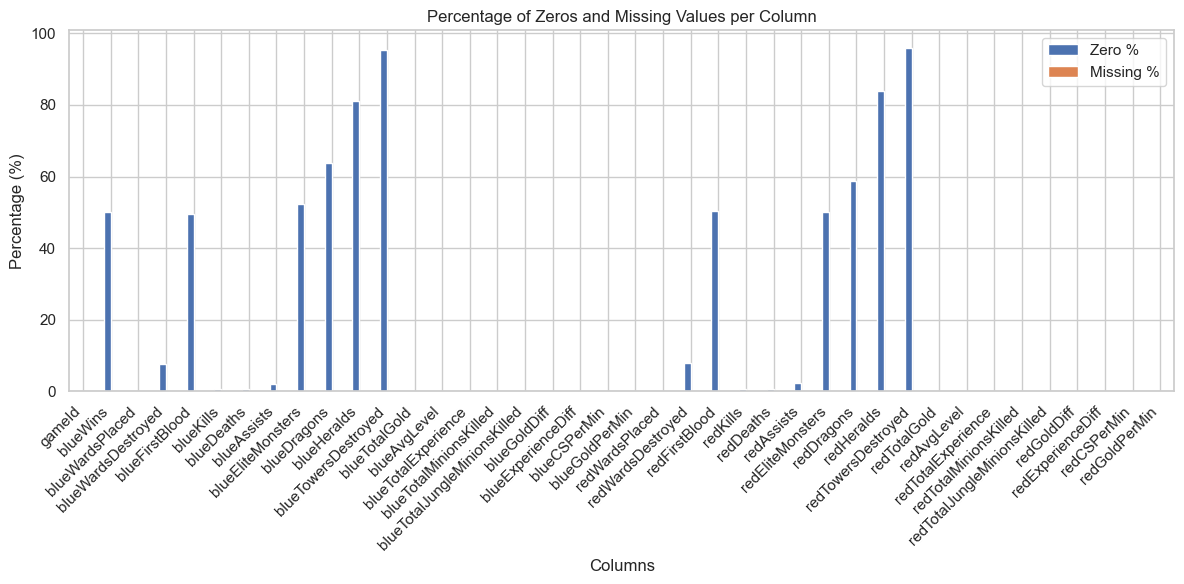

Saved plot to report: Data Quality Check

== Generating Data Exploration Visualisations ==


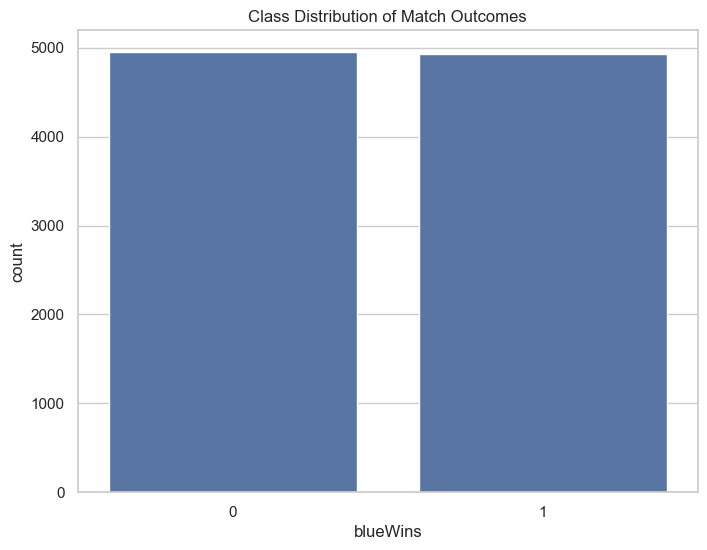

Saved plot to report: Class Balance


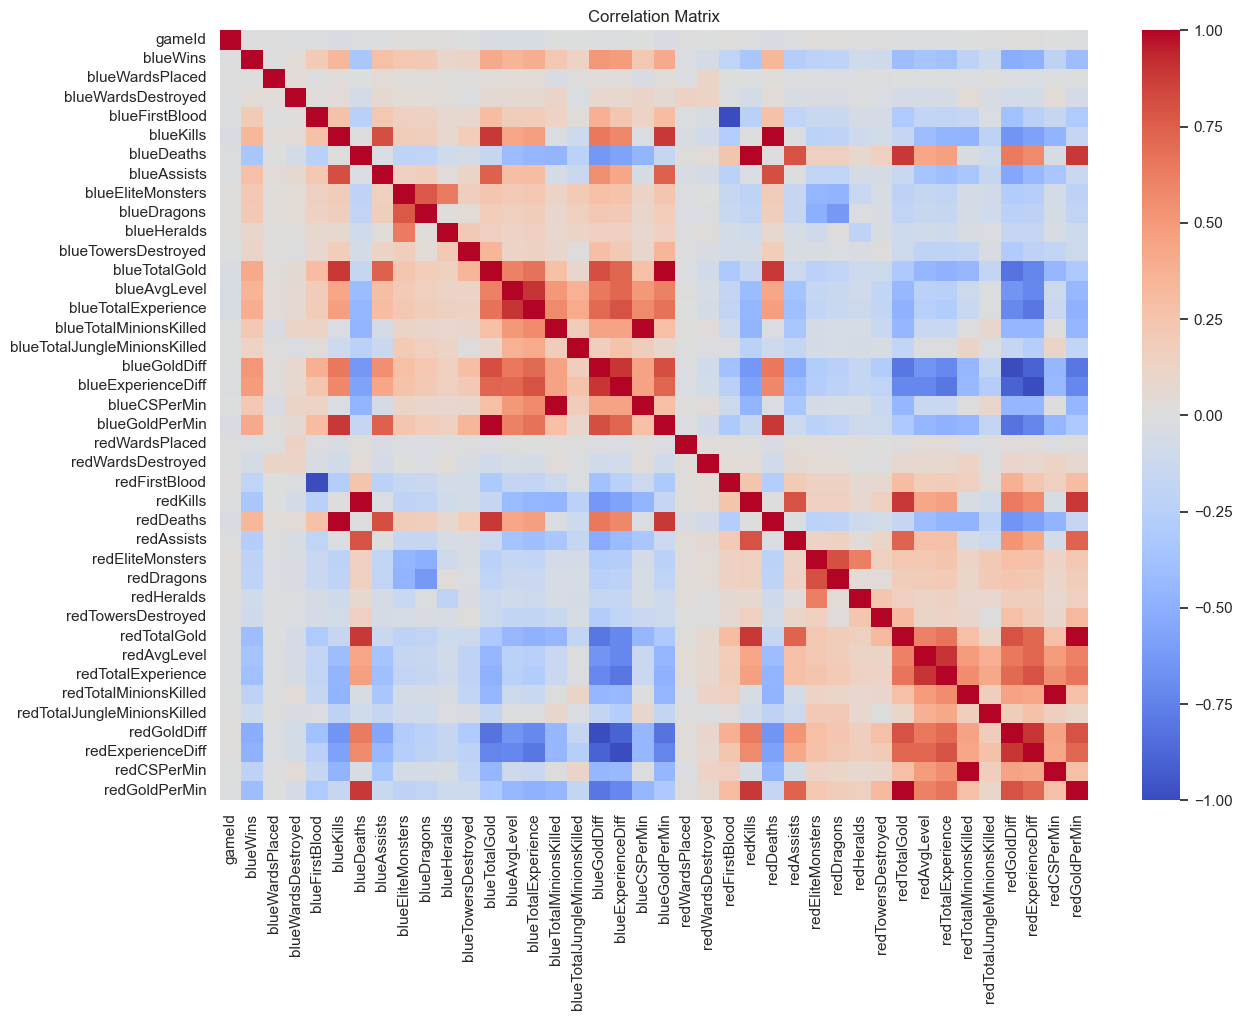

Saved plot to report: Correlation Matrix


<Figure size 1000x800 with 0 Axes>

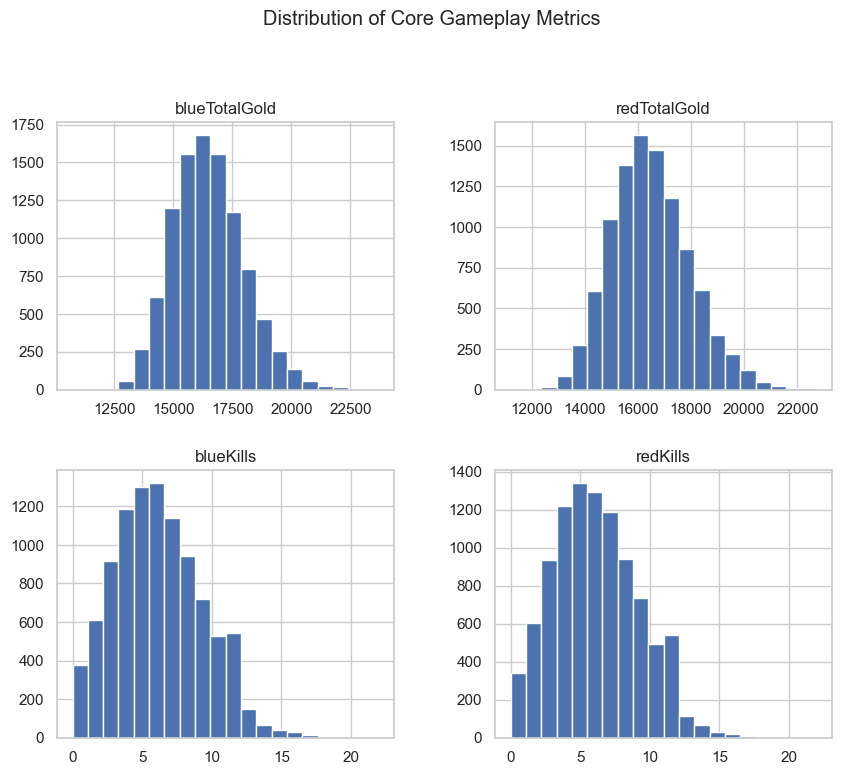

Saved plot to report: Metric Distributions

ANALYSIS COMPLETE


In [8]:
# Section 1: Data Initialization
report_gen = ReportGenerator("LoL_Analysis_Report.pdf")

data_handler = LoLDataHandler('high_diamond_ranked_10min.csv', report_gen)
data_handler.load_data()
data_handler.run_full_analysis(zero_threshold=50)


## 2. Cleaning & Dimensionality Reduction

STARTING CLEANUP: 40 initial columns.

[1] LEAKAGE REMOVAL: Dropped 14 columns.

[2] RATIO TRANSFORMATION: Dropped 8 raw component columns.
    -> Created: ['killsRatio', 'assistsRatio', 'minionsRatio', 'jungleRatio']

CLEANUP COMPLETE: 22 columns remaining.
------------------------------
Running t-SNE...


C:\Users\Kiero\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Kiero\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Running UMAP...


C:\Users\Kiero\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 640x480 with 0 Axes>

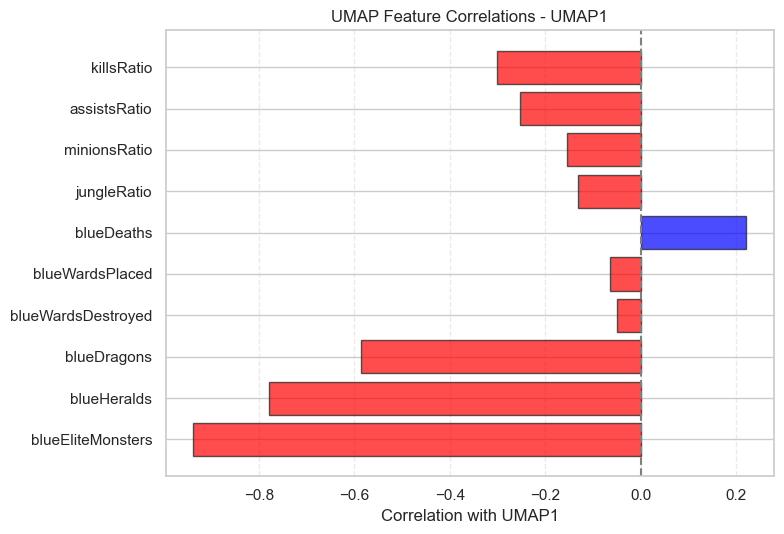

Saved plot to report: Correlations UMAP1


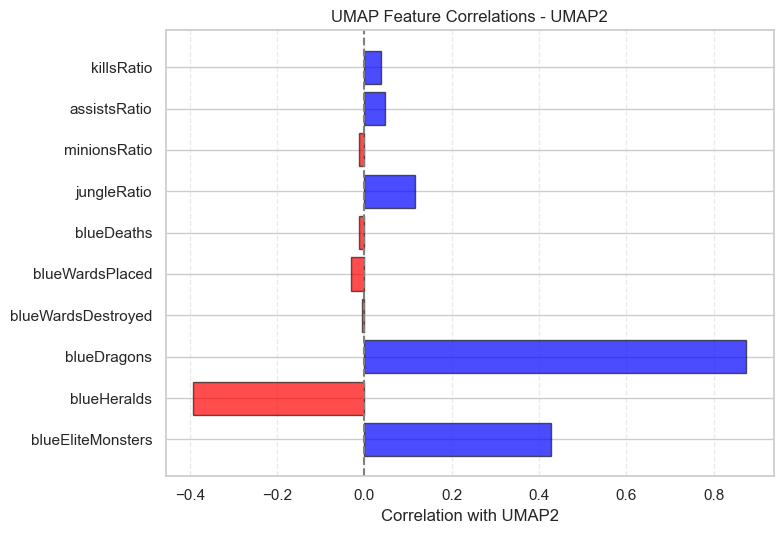

Saved plot to report: Correlations UMAP2


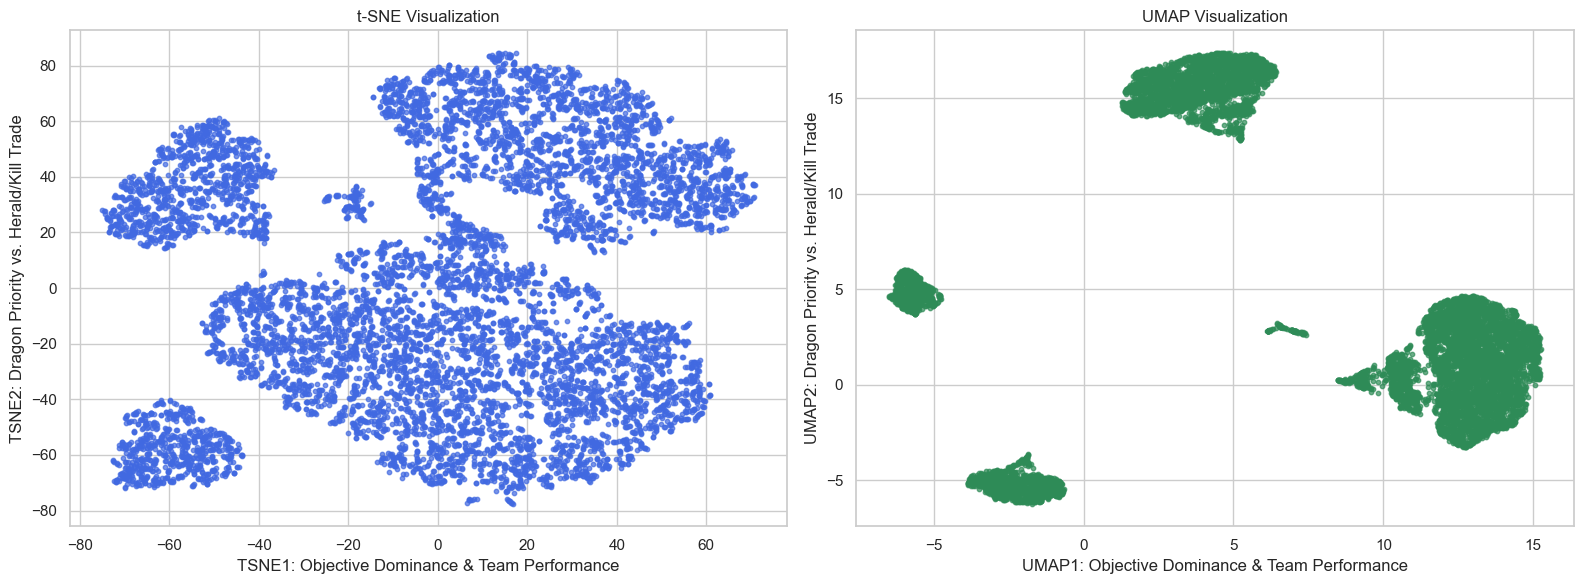

Saved plot to report: t-SNE vs UMAP


In [9]:
# Section 2: Data Cleaning
cleaner = LoLDataCleaner(data_handler.df_raw)
df_cleaned = cleaner.run_full_cleanup()

# Section 3: Dimensionality Reduction
feature_columns_cluster = [
    'killsRatio', 'assistsRatio', 'minionsRatio', 'jungleRatio',
    'blueDeaths', 'blueWardsPlaced', 'blueWardsDestroyed',
    'blueDragons', 'blueHeralds', 'blueEliteMonsters'
]
dim_reducer = DimensionalityReducer(df_cleaned, feature_columns_cluster, report_gen)
X_scaled = dim_reducer.prepare_data()
X_tsne, X_umap = dim_reducer.run_reductions()
dim_reducer.analyze_component_correlations() # Shap-style bar plot (Snippet Logic)
dim_reducer.plot_reductions() # t-SNE & UMAP scatter (Snippet Logic)


## 3. Clustering Analysis

Calculating Inertia and Silhouette Scores...


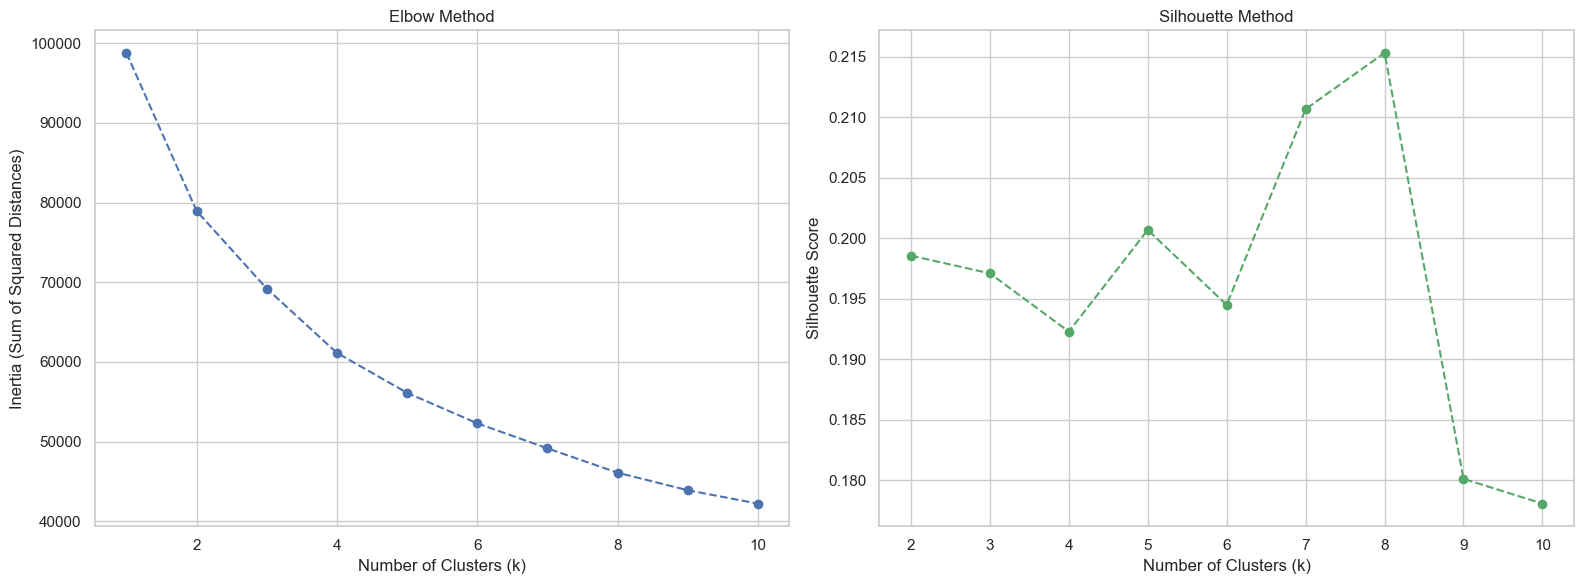

Saved plot to report: Clustering Optimization


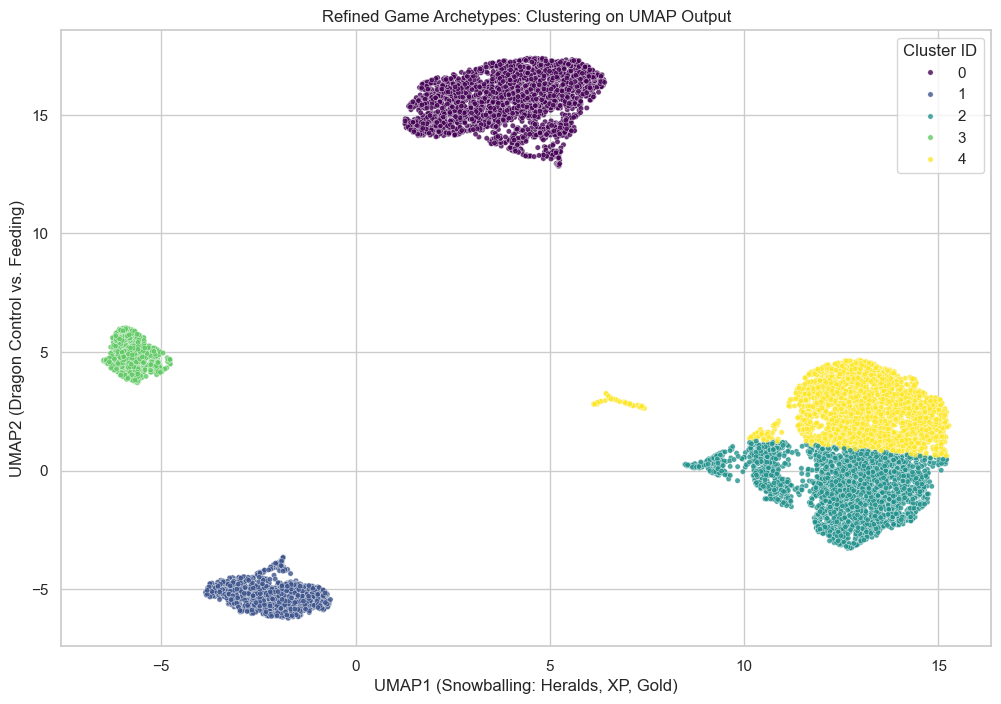

Saved plot to report: UMAP Clusters

--- CLUSTER WIN RATE INTERPRETATION ---
         blueWins  blueEliteMonsters  blueDeaths  killsRatio  Game_Count
Cluster                                                                 
0           0.619              0.634       4.375       0.159        4312
2           0.506              0.587       6.017       0.009        1265
1           0.488              0.650       6.650      -0.052          80
3           0.465              0.535       6.277       0.004         282
4           0.368              0.446       8.085      -0.172        3940


C:\Users\Kiero\AppData\Local\Temp\ipykernel_19068\642815221.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_win_analysis.index, y=cluster_win_analysis['blueWins'], palette=palette_ordered, order=plot_order, edgecolor="black")


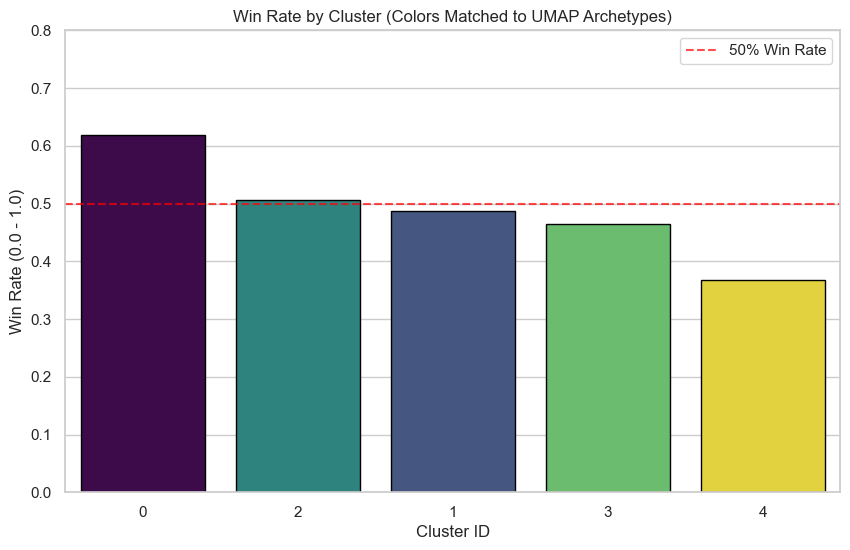

Saved plot to report: Win Rate by Cluster


In [10]:
# Section 4: Clustering Analysis
cluster_analyzer = ClusterAnalyzer(X_scaled, random_state=42, report_gen=report_gen)
cluster_analyzer.find_optimal_k() # Elbow / Silhouette

# 1. Cluster on UMAP (Purely for visual archetype identification - Snippet Step)
clusters_umap = cluster_analyzer.cluster_on_umap_and_visualize(X_umap, n_clusters=5)

# 2. Cluster on Data Features (For Win Rate Analysis - Snippet Step)
# This matches the user's specific feature list for this step:
feature_columns_for_winrate = [
    'killsRatio', 'assistsRatio', 'minionsRatio', 'jungleRatio',
    'blueDeaths', 'blueWardsPlaced', 'blueWardsDestroyed',
    'blueDragons', 'blueHeralds', 'blueEliteMonsters'
]
cluster_win_df, clusters_raw = cluster_analyzer.analyze_win_rates(df_cleaned, feature_columns_for_winrate)


## 4. Modeling & Classification

Testing Random Forest on Raw Data...
Testing Random Forest on Clusters Data...
Testing Random Forest on Combined Data...
Testing Gradient Boosting on Raw Data...
Testing Gradient Boosting on Clusters Data...
Testing Gradient Boosting on Combined Data...
Testing Logistic Regression on Raw Data...
Testing Logistic Regression on Clusters Data...
Testing Logistic Regression on Combined Data...
Testing Naïve Bayes on Raw Data...
Testing Naïve Bayes on Clusters Data...
Testing Naïve Bayes on Combined Data...
Testing SVM (RBF) on Raw Data...
Testing SVM (RBF) on Clusters Data...
Testing SVM (RBF) on Combined Data...


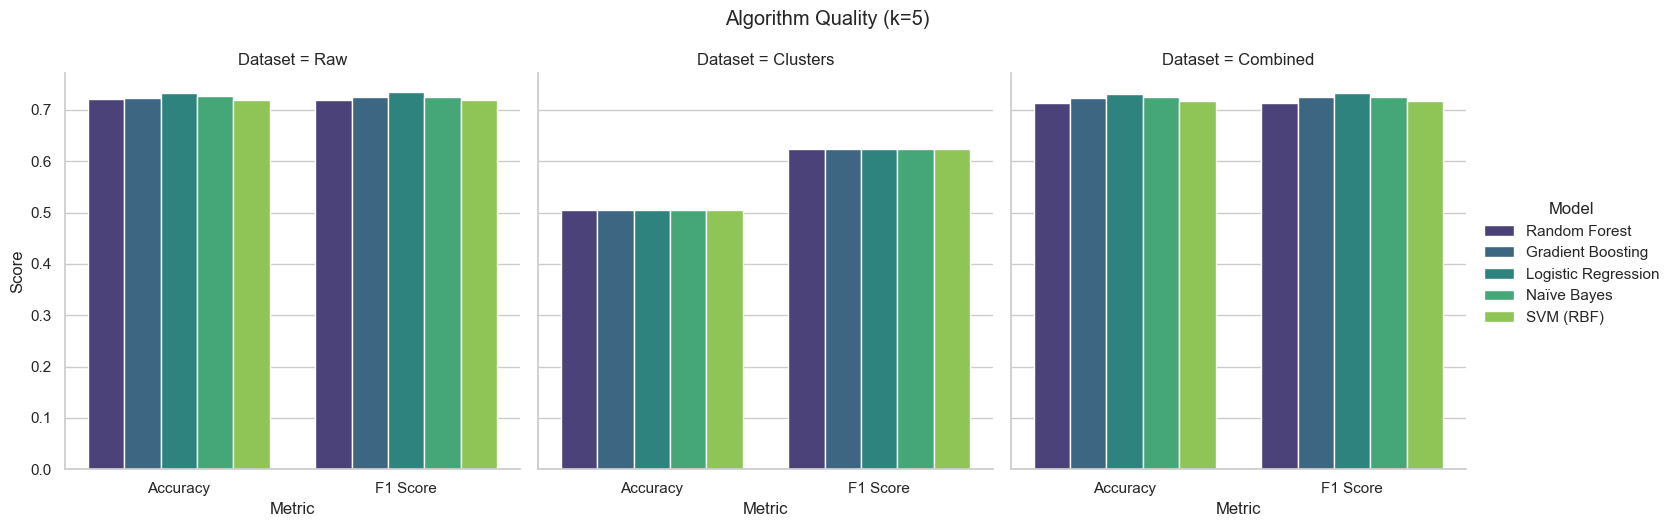

Saved plot to report: Algorithm Quality Comparison


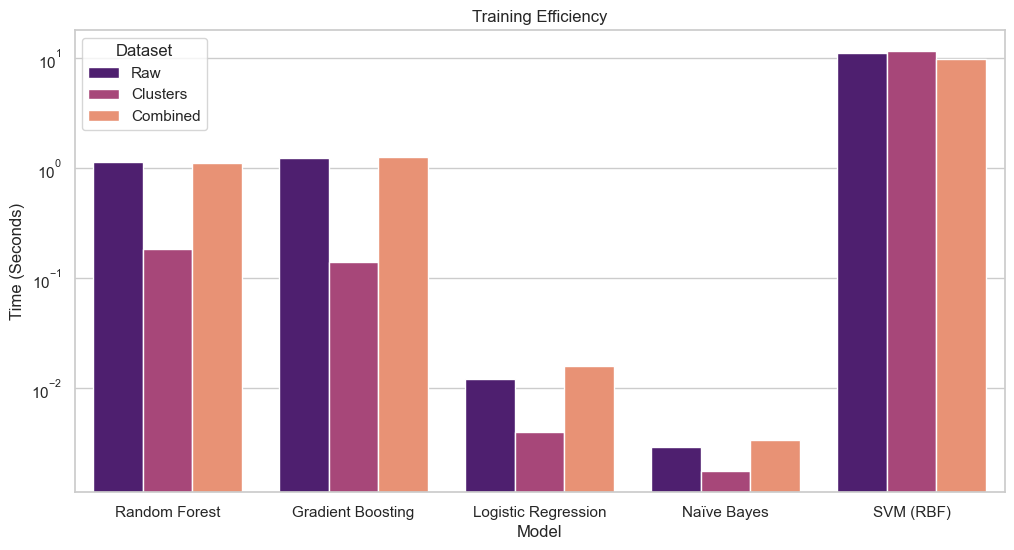

Saved plot to report: Training Efficiency


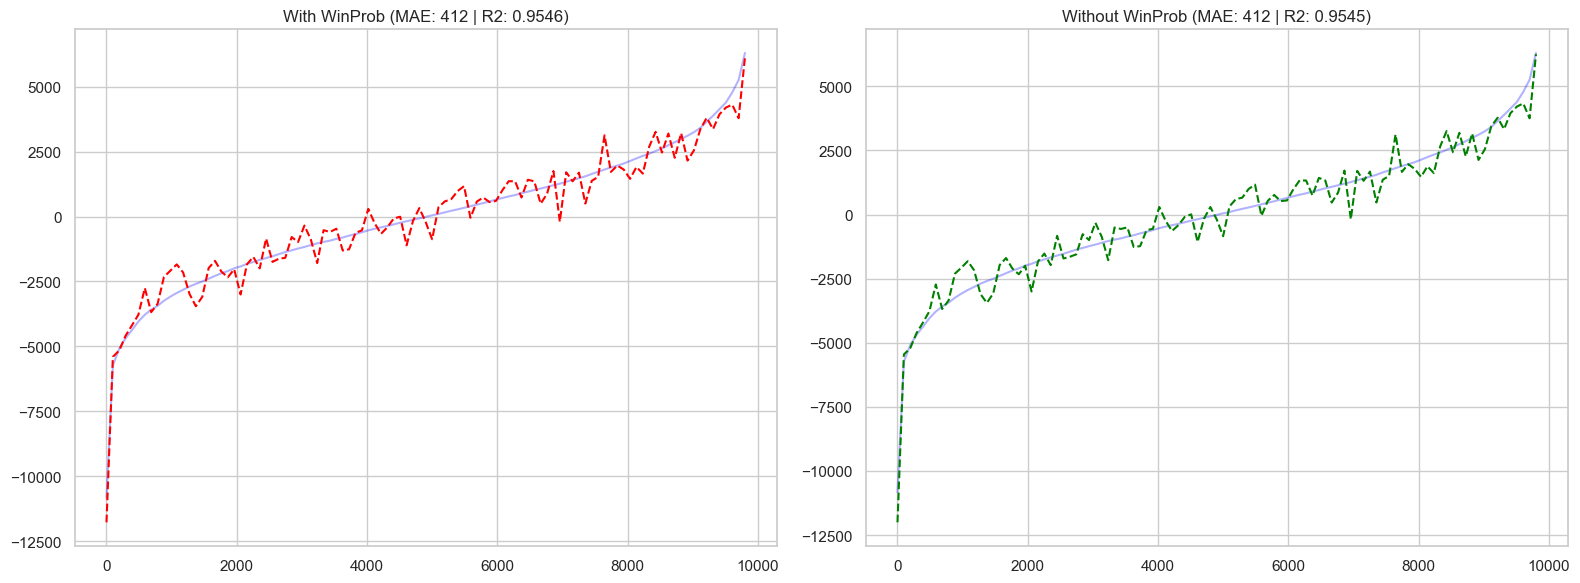

Saved plot to report: Regression Analysis
Report successfully saved to LoL_Analysis_Report.pdf


In [11]:
# Section 5: Classification & Regression
# Prepare Datasets
X_raw_for_clustering = df_cleaned.drop(['blueWins'], axis=1)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_raw_for_clustering)

df_classification = df_cleaned.copy()
df_classification['Cluster'] = clusters
df_classification = pd.get_dummies(df_classification, columns=['Cluster'], prefix='Cluster')

cluster_cols = [col for col in df_classification.columns if col.startswith('Cluster_')]
X_raw_stats = df_classification.drop(['blueWins'] + cluster_cols, axis=1)
X_clusters = df_classification[cluster_cols]
X_combined = df_classification.drop(['blueWins'], axis=1)
y = df_classification['blueWins']

datasets = {
    'Raw': {'X_train': None, 'X_test': None}, # Populated below
    'Clusters': {'X_train': None, 'X_test': None},
    'Combined': {'X_train': None, 'X_test': None},
    'y_train': None, 'y_test': None
}

# Split data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw_stats, y, test_size=0.2, random_state=42)
X_train_clust, X_test_clust, _, _ = train_test_split(X_clusters, y, test_size=0.2, random_state=42)
X_train_comb, X_test_comb, _, _ = train_test_split(X_combined, y, test_size=0.2, random_state=42)

datasets['Raw']['X_train'], datasets['Raw']['X_test'] = X_train_raw, X_test_raw
datasets['Clusters']['X_train'], datasets['Clusters']['X_test'] = X_train_clust, X_test_clust
datasets['Combined']['X_train'], datasets['Combined']['X_test'] = X_train_comb, X_test_comb
datasets['y_train'], datasets['y_test'] = y_train, y_test

# Run Models
trainer = ModelTrainer(random_state=42)
runner = ExperimentRunner(trainer, report_gen)
results_df = runner.run_classifier_comparison(datasets)
runner.visualize_results(results_df, optimal_k=5)

# Regression
gb_model = trainer.models['Gradient Boosting']
runner.run_regression_analysis(df_classification, gb_model, X_combined, data_handler.df_raw['blueGoldDiff'])

# Save PDF
report_gen.save_report()
